![](https://i.imgur.com/eBRPvWB.png)

# Tłumaczenie typu Sequence 2 Sequence 


W tym projekcie nauczymy sieci neuronowej, aby przetłumaczyć z angielskiego na polski, przykłady jednak poniższe pokazują zasadę działania na przykładzie tłumaczenia z francuskiego na angielski.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```


... w różnym stopniu sukcesu.

Jest to możliwe dzięki prostej, ale mocnej idei [sekwencji do sekwencji sieci](http://arxiv.org/abs/1409.3215), w której dwie powtarzające się sieci neuronowe współpracują ze sobą, aby przekształcić jedną sekwencję w drugą. Sieć koderów skrapla sekwencję wejściową do pojedynczego wektora, a sieć dekodera rozwija ten wektor w nową sekwencję.

Aby ulepszyć ten model, użyjemy [mechanizmu uwagi](https://arxiv.org/abs/1409.0473), który pozwoli dekodowi nauczyć się skupiać na określonym zakresie sekwencji wejściowych.

# Model Sequence 2 Sequence


Sieć [Sequence to Sequence](http://arxiv.org/abs/1409.3215) lub seq2seq network lub [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), jest to model składający się z dwóch oddzielnych RNN zwanych **enkoderem** i **dekoderem**. Enkoder odczytuje sekwencję wejściową po jednym elemencie i wyprowadza wektor na każdym kroku. Końcowy wynik enkodera jest utrzymywany jako **kontekst**. Dekoder wykorzystuje ten wektor kontekstowy, aby wytworzyć sekwencję wyjść jeden krok na raz.

![](https://i.imgur.com/tVtHhNp.png)

Podczas korzystania z pojedynczego RNN istnieje relacja jeden do jednego pomiędzy wejściami i wyjściami. Szybko napotkaliśmy problemy z różnymi kolejnościami i długościami, które są częste podczas tłumaczenia. Rozważ proste zdanie "Je ne suis pas le chat noir" & rarr; "I am not the black cat" ("Nie jestem czarnym kotem"). Wiele słów ma całkiem bezpośrednie tłumaczenie, na przykład "chat" i rarr; "cat". Jednak różne gramatyki powodują, że słowa występują w różnych rzędach, np. "chat noir" i "black cat". Istnieje również "ne ... pas" i rarr; "not" konstrukcja, która sprawia, że dwa zdania mają różne długości.

W modelu seq2seq, kodując wiele wejść do jednego wektora i dekodując z jednego wektora na wiele wyjść, jesteśmy uwolnieni od ograniczeń kolejności i długości sekwencji. Zakodowana sekwencja jest reprezentowana przez pojedynczy wektor, pojedynczy punkt w N-wymiarowej przestrzeni sekwencji. W idealnym przypadku punkt ten można uznać za "znaczenie" sekwencji.

Ten pomysł może zostać przedłużony poza sekwencje. Zadania tworzenia napisów pobierają [obraz jako dane wejściowe i wypisują opis](https://arxiv.org/abs/1411.4555) obrazu (img2seq). Niektóre zadania generowania obrazów pobierają [opis jako dane wyjściowe i wygenerowany obraz](https://arxiv.org/abs/1511.02793) (seq2img). Modele te można ogólnie określić jako sieci "enkodera dekodera".

## Mechanizm Atencji

Wektor o stałej długości niesie ze sobą obciążenie kodowaniem całego "znaczenia" sekwencji wejściowej, bez względu na to, jak długo to trwa. Przy całej wariancji językowej jest to bardzo trudny problem. Wyobraź sobie dwa prawie identyczne zdania, dwadzieścia słów, z jednym tylko słowem innym. Zarówno enkodery, jak i dekodery muszą być wystarczająco zniuansowane, aby reprezentować tę zmianę jako bardzo nieznacznie inny punkt w przestrzeni.

Mechanizm **attention** [wprowadzony przez Bahdanau i innych](https://arxiv.org/abs/1409.0473) rozwiązuje ten problem, dając dekoderowi możliwość "zwrócenia uwagi" na części danych wejściowych, zamiast polegania na nich. na jednym wektorze. Dla każdego kroku dekoder może wybrać inną część zdania wejściowego do rozważenia.

![](https://i.imgur.com/5y6SCvU.png)

Atencja jest obliczana za pomocą kolejnej warstwy feedforward w dekoderze. Ta warstwa użyje bieżącego wejścia i stanu ukrytego, aby utworzyć nowy wektor, który ma taki sam rozmiar jak sekwencja wejściowa (w praktyce stała maksymalna długość). Wektor ten jest przetwarzany przez softmax, aby utworzyć *attention weights*, które są mnożone przez wyjścia enkoderów w celu utworzenia nowego wektora kontekstowego, który jest następnie wykorzystywany do przewidywania następnego wyniku.

![](https://i.imgur.com/K1qMPxs.png)



# Wymagania

Będziesz potrzebował [PyTorch](http://pytorch.org/), aby zbudować i wyszkolić modele, i [matplotlib](https://matplotlib.org/), aby wykreślić trenowanie i zwizualizować później wyniki atencji.

In [0]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Tutaj również zdefiniujemy stałą, aby zdecydować, czy użyć GPU (w szczególności z CUDA), czy procesora. **Jeśli nie masz GPU, ustaw dla niego wartość `False`**. Później, kiedy stworzymy tensory, zmienna ta będzie używana do decydowania o tym, czy zachowamy je na procesorze, czy przeniesiemy na GPU.

In [0]:
USE_CUDA = True

# Ładowanie plików danych

Dane do tego projektu to zbiór wielu tysięcy par tłumaczeń z angielskiego na francuski.

[To pytanie na temat Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) skierowało mnie na stronę otwartego tłumaczenia http://tatoeba.org/ który ma pliki do pobrania dostępne na stronie http://tatoeba.org/eng/downloads - a jeszcze lepiej, ktoś wykonał dodatkową pracę polegającą na podzieleniu par językowych na poszczególne pliki tekstowe tutaj: http://www.manythings.org/anki/

Angielsko-francuskie pary są zbyt duże, by je uwzględnić w repozytorium, więc pobierz plik `fra-eng.zip`, wypakuj plik tekstowy i zmień jego nazwę na`data/eng-fra.txt` przed kontynuowaniem (z jakiegoś powodu plik zip nazywa się wstecz). Plik jest oddzielonymi tabulatorami parami tłumaczeń:

```
I am cold.    Je suis froid.
```

Podobnie jak w przypadku kodowania używanego w RNN na poziomie znaków, będziemy reprezentować każde słowo w języku jako wektor lub gigantyczny wektor zer, z wyjątkiem pojedynczego (w indeksie słowa). W porównaniu z dziesiątkami znaków, które mogą istnieć w języku, istnieje wiele wiele słów, więc wektor kodowania jest znacznie większy. Będziemy jednak trochę oszukiwać i trymować dane, aby używać tylko kilku tysięcy słów na język.

### Indeksowanie słów

Będziemy potrzebować unikalnego indeksu dla każdego słowa słowa, który później posłuży jako dane wejściowe i wyjściowe. Aby śledzić to wszystko, użyjemy klasy pomocniczej o nazwie `Lang`, która ma słowniki słowo &rarr; indeks (`word2index`) i indeks &rarr; słowo (`index2word`), a także licznik każdego słowa `word2count`, którego można użyć do późniejszego zastąpienia rzadkich słów.

In [0]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Czytanie i dekodowanie plików

Wszystkie pliki są w Unicode, aby uprościć, zamienimy znaki Unicode na ASCII, zrobimy wszystko małymi literami i wycinamy większość znaków interpunkcyjnych.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# don't kill Polish diacritics
  
# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
normalize_string('ala ma kota ąćęłńóśźż ĄĆĘŁŃÓŚŹŻ')

'ala ma kota ąćęłńóśźż ąćęłńóśźż'

Aby odczytać plik danych, podzielimy go na linie, a następnie podzielimy linie na pary. Wszystkie pliki są angielskie  &rarr; Inny język, więc jeśli chcemy przetłumaczyć z Innego języka &rarr; Angielski dodana została flaga `reverse`, aby odwrócić pary.

In [0]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/seq2seq/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs
  
  
# input_lang, output_lang, pairs = read_langs('eng', 'pol', reverse=False)
# pairs[0]

### Filtrowanie zdań

Ponieważ istnieje *dużo* przykładowych zdań i chcemy szybko coś wytrenować, zmienimy zestaw danych tylko na względnie krótkie i proste zdania. Tutaj maksymalna długość to 10 słów (w tym interpunkcja), a my filtrujemy zdania, które tłumaczą się na formę "Jestem" (I am) lub "Jest" (He is) itd. (Z uwzględnieniem usuwania apostrofów).

In [0]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        (p[1].startswith(good_prefixes) or p[0].startswith(good_prefixes))

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]
  
  
# print(pairs[0])

# print(filter_pairs(pairs))
# print(filter_pair(pairs[0]))

Pełny proces przygotowywania danych to:

* Czytaj plik tekstowy i podziel na linie, podziel linie na pary
* Normalizuj tekst, filtruj według długości i zawartości
* Twórz listy słów ze zdań w parach

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print(pairs[0])
    print("Read %s sentence pairs" % len(pairs))
    # %debug 
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print(pairs[0])
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'pol', reverse=False)

# Print an example pair
print(random.choice(pairs))

Reading lines...
['hi .', 'cześć .']
Read 36856 sentence pairs
Trimmed to 615 sentence pairs
['i am hot .', 'jest mi gorąco .']
Indexing words...
['i am just going for a walk .', 'wychodzę tylko na spacer .']


## Włączanie danych treningowych do Tensorów / Zmiennych

Aby trenować, musimy przekształcić zdania w coś, co sieć neuronowa może zrozumieć, co oczywiście oznacza liczby. Każde zdanie zostanie podzielone na słowa i przekształcone w Tensor, gdzie każde słowo zostanie zastąpione indeksem (z wcześniejszych indeksów Langa). Podczas tworzenia tych tensorów dodamy również token EOS, aby zasygnalizować, że zdanie jest skończone.

![](https://i.imgur.com/LzocpGH.png)

Tensor jest wielowymiarową tablicą liczb, określoną za pomocą pewnego typu, np. FloatTensor lub LongTensor. W tym przypadku użyjemy LongTensor do reprezentowania tablicy indeksów całkowitych.

Szkolne moduły PyTorch przyjmują zmienne jako dane wejściowe, a nie zwykłe Tensory. Zmienna jest w zasadzie tensorem, który jest w stanie śledzić stan wykresu, co umożliwia automatyczne autogradzanie (automatyczne obliczanie gradientów wstecznych).

In [0]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Budowanie modeli

## Enkoder

<img src="https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/images/encoder-network.png?raw=true" style="float: right" />

Enkoder sieci seq2seq to RNN, który wyprowadza pewną wartość dla każdego słowa ze zdania wejściowego. Dla każdego słowa wejściowego enkoder wyprowadza wektor i stan ukryty oraz wykorzystuje stan ukryty dla następnego słowa wejściowego.


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Dekoder Atencji

### Interpretacja modelu Bahdanau

Model atencji w [Neurowe tłumaczenie maszynowe przez wspólne uczenie się wyrównywania i tłumaczenia](https://arxiv.org/abs/1409.0473) jest opisany jako następująca seria równań:

Każde wyjście dekodera jest uwarunkowane poprzednimi wyjściami i pewnym $\mathbf x$, gdzie $\mathbf x $składa się z bieżącego stanu ukrytego (który bierze pod uwagę poprzednie wyjścia) i "kontekstu" uwagi, który jest obliczany poniżej. Funkcja $g$ jest w pełni połączoną warstwą z nieliniową aktywacją, która jako dane wejściowe przyjmuje połączone wartości $y_{i-1}$, $s_i$ i $c_i$.


$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

Bieżący stan ukryty $s_i$ jest obliczany przez RNN $f$ z ostatnim ukrytym stanem $s_{i-1}$, ostatnią wartością wyjściową dekodera $y_{i-1}$  i wektorem kontekstowym $c_i$.
W kodzie RNN będzie warstwą `nn.GRU`, ukryty stan $s_i$ będzie nazywany `hidden`, wyjście $y_i$ zwane `output` oraz kontekst $c_i$ zwany `context`.


$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Wektor kontekstowy $c_i$ jest ważoną sumą wszystkich wyników enkodera, gdzie każda waga $a_{ij}$ jest ilością "atencji" przekazanej na odpowiednie wyjście enkodera $h_j$.


$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... gdzie każda waga $a_{ij}$ to znormalizowana (ponad wszystkie kroki) atencja "energia" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... gdzie każda energia atencji jest obliczana za pomocą funkcji $a$ (takiej jak inna warstwa liniowa) przy użyciu ostatniego ukrytego stanu $s_{i-1}$ i tego konkretnego wyjścia enkodera $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Implementacja modelu Bahdanau

Podsumowując, nasz dekoder powinien składać się z czterech głównych części - warstwy osadzającej, zamieniającej słowo wejściowe w wektor; warstwa do obliczenia energii uwagi na wyjście enkodera; warstwa RNN; i warstwę wyjściową.

Wejścia dekodera są ostatnim ukrytym stanem RNN $s_{i-1}$, ostatnie wyjście $y_{i-1}$ oraz wszystkie wyjścia enkodera $h_*$.

* warstwa osadzania z wejściami $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* warstwa atencji $a$ z wejściami $(s_{i-1}, h_j)$ i wyjściami $e_{ij}$, znormalizowanymi w celu utworzenia $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* wektor kontekstowy $c_i$ jako średnia ważona wyjść enkodera
    * `context = sum(attn_weights * encoder_outputs)`
* warstwa (warstwy) RNN $f$ z wejściami $(s_{i-1}, y_{i-1}, c_i)$ i wewnętrznym stanem ukrytym, wyprowadzanie $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* warstwa wyjściowa $g$ z wejściami $(y_{i-1}, s_i, c_i)$, wyprowadzanie $y_i$
    * `output = out(embedded, rnn_output, context)`



In [0]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

### Interpretacja modelu Luong'a



[Skuteczne podejście do neuronowego tłumaczenia maszynowego z naciskiem na atencję](https://arxiv.org/abs/1508.04025) autorstwa Luonga i innych. opisuje kilka modeli atencji, które oferują ulepszenia i uproszczenia. Opisują kilka modeli "globalnej atencji", a rozróżnienie między nimi jest sposobem obliczania wyników atencji.

Ogólna forma obliczania atencji opiera się na ukrytym stanie po stronie docelowej (dekodera) i odpowiednim stanie bocznym źródła (enkodera), znormalizowanym dla wszystkich stanów, aby uzyskać wartości zsumowane do 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

Konkretną funkcją "wyniku" (score), która porównuje dwa stany, jest albo *dot* (kropka), prosty produkt punktowy między stanami; *general* (ogólnie), produkt kropki między ukrytym stanem dekodera a liniową transformacją stanu kodera; lub *concat*, produkt kropki między nowym parametrem $v_a$ a liniową transformacją stanów połączonych ze sobą.


$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

Modułowa definicja tych funkcji ewaluacji daje nam możliwość zbudowania specjalnego modułu atencji, który może przełączać się między różnymi metodami punktacji. Wejście do tego modułu jest zawsze stanem ukrytym (dekodera RNN) i zestawem wyjść enkodera.


In [0]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        # return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
        return F.softmax(attn_energies, dim=-1).unsqueeze(0).unsqueeze(0)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.other.dot(energy)
#             return energy
          
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

Teraz możemy zbudować dekoder, który podłącza ten moduł Attn za RNN, aby obliczyć wagi atencji, i zastosować te wagi do wyjść enkodera, aby uzyskać wektor kontekstu.


In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        # output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

### Testowanie modelu

Aby upewnić się, że model kodera i dekodera działa (i współpracują ze sobą), wykonamy szybki test z fałszywymi słowami wejściowymi:


In [13]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


# Trenowanie

## Definiowanie iteracji treningu

Aby ćwiczyć, najpierw uruchamiamy zdanie wejściowe za pomocą enkodera słowo po słowie i śledzimy każde wyjście i ostatni stan ukryty. Następnie dekoder otrzymuje ostatni ukryty stan dekodera jako swój pierwszy ukryty stan, a token "<SOS>" jako pierwsze wejście. Stąd przechodzimy do przepowiadania następnego tokena z dekodera.

### "Wymuszanie nauczycieli" i planowe pobieranie próbek

"Wymuszanie nauczycieli" lub pobieranie próbek o największej wiarygodności oznacza wykorzystanie rzeczywistych wyników docelowych jako każdego następnego wejścia podczas treningu. Alternatywą jest użycie własnego odgadnięcia przez dekoder jako następnego wejścia. Korzystanie z wymuszania nauczyciela może spowodować szybsze zbieganie się sieci, ale [kiedy wyszkolona sieć jest wykorzystywana, może wykazywać niestabilność](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

Możesz obserwować wyniki wymuszonych przez nauczyciela sieci, które czytają ze spójną gramatyką, ale oddalają się od prawidłowego tłumaczenia - możesz myśleć o tym, że nauczyłeś się słuchać instrukcji nauczyciela, nie ucząc się samodzielnego wyjścia.

Rozwiązanie problemu "wymuszania" nauczyciela jest znane jako [Zaplanowane próbkowanie](https://arxiv.org/abs/1506.03099), które po prostu przełącza się między wartościami docelowymi i przewidywanymi wartościami podczas trenowania. My losowo wybieramy użycie wymuszania nauczyciela instrukcją if podczas treningu - czasami będziemy podawać rzeczywisty cel jako wejście (ignorując wyjście dekodera), czasami użyjemy wyjścia dekodera.


In [0]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            # loss += criterion(decoder_output[0], target_variable[di])
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            # loss += criterion(decoder_output[0], target_variable[di])
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    # torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    # torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # return loss.data[0] / target_length
    return loss.item() / target_length

Wreszcie funkcje pomocnicze do wydrukowania czasu i szacowanego czasu pozostałego do końca, biorąc pod uwagę aktualny czas i postęp.


In [0]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Uruchamianie treningu

Gdy wszystko jest gotowe, możemy zainicjować sieć i rozpocząć trening.

Na początek uruchamiamy modele, optymalizatory i funkcję utraty (kryterium).

In [0]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Następnie skonfiguruj zmienne do drukowania i śledzenia postępu:

In [0]:
# Configuring training
n_epochs = 1000 # 50000
plot_every = 200
print_every = 500

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

Żeby przeprowadziwy właściwy trening, wielokrotnie wywołujemy funkcję treningową.


In [18]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 43s (- 0m 43s) (500 50%) 3.9487
1m 28s (- 0m 0s) (1000 100%) 3.5206


## Wyrysowywanie strat treningowych

Wykreślanie odbywa się za pomocą matplotlib, przy użyciu macierzy `plot_losses`, która została utworzona podczas treningu.


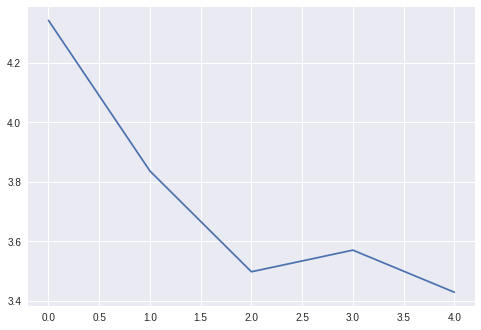

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import matplotlib.style
import matplotlib as mpl
import numpy as np
# %matplotlib inline
# mpl.style.use('default')
mpl.style.use('seaborn')
# mpl.style.use('classic')
# mpl.style.use('bmh')
# mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Ewaluacja sieci

Ewaluacja jest w większości taka sama jak w przypadku treningu, ale nie ma żadnych wyników. Zamiast tego zawsze podajemy prognozy dekodera z powrotem do siebie. Za każdym razem, gdy przewiduje słowo, dodajemy je do ciągu wyjściowego. Jeśli przewiduje to token EOS, zatrzymujemy się tam. Przechowujemy także wyniki uwagi dekodera dla każdego kroku, aby wyświetlić później.


In [0]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            # decoded_words.append(output_lang.index2word[ni])
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

Możemy oceniać losowe zdania z zestawu treningowego i drukować dane wejściowe, docelowe i wyjściowe w celu dokonania subiektywnej oceny jakości:

In [0]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [22]:
evaluate_randomly()

> she spoke rapidly .
= mówiła szybko .
< ona się . <EOS>



# Wizualizacja atencji

Użyteczną właściwością mechanizmu atencji są jego wysoce interpretowalne wyniki. Ponieważ jest on używany do ważenia określonych wyjść kodera sekwencji wejściowej, możemy sobie wyobrazić, gdzie najlepiej jest skupić się w sieci na każdym kroku.

Możesz po prostu uruchomić `plt.matshow(attentions)`, aby zobaczyć wyniki atencji wyświetlane jako matryca, z kolumnami będącymi krokami wejściowymi i wierszami będącymi krokami wyjściowymi:

In [23]:
xxx=[print(random.choice(pairs)) for i in range(10)]

['he is very direct about it .', 'on jest co do tego bardzo bezpośredni .']
['i am anxious about the future .', 'martwię się o przyszłość .']
['you are supposed to come in person .', 'masz przyjść osobiście .']
['he is hunted by the police .', 'on jest ścigany przez policję .']
['he is the fastest runner in his class .', 'jest najszybszym biegaczem w swojej klasie .']
['she stood up and walked to the window .', 'wstała i podeszła do okna .']
['i am a member of the tennis club .', 'jestem członkiem klubu tenisowego .']
['she is the one who feeds our dog .', 'to ona karmi naszego psa .']
['i am a student at london university .', 'studiuję na uniwersytecie londyńskim .']
['he is a man of great ability .', 'to człowiek bardzo utalentowany .']


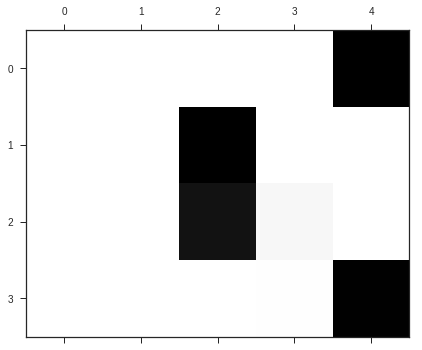

In [24]:
# mpl.style.use('default')
mpl.style.use('seaborn')
# mpl.style.use('classic')
# mpl.style.use('bmh')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

output_words, attentions = evaluate("i am hot .")
fig=plt.matshow(attentions.numpy())

Aby uzyskać lepsze wrażenia wizualne, wykonamy dodatkową pracę dodawania osi i etykiet:

In [0]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = he is ill .
output = on jest . . <EOS>


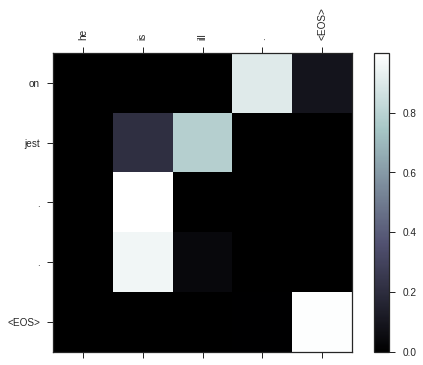

In [26]:
evaluate_and_show_attention("he is ill .")

input = she spoke to me in spanish .
output = ona się . <EOS>


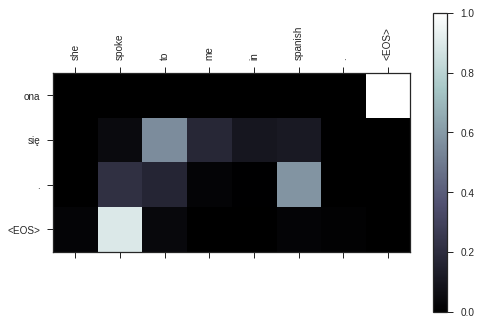

In [27]:
evaluate_and_show_attention("she spoke to me in spanish .")

input = i am good .
output = jestem z . <EOS>


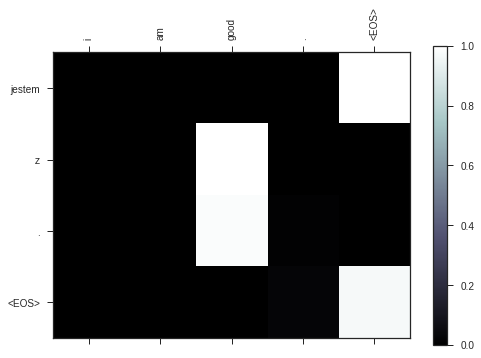

In [28]:
evaluate_and_show_attention("i am good .")

input = i am tall .
output = jestem z . <EOS>


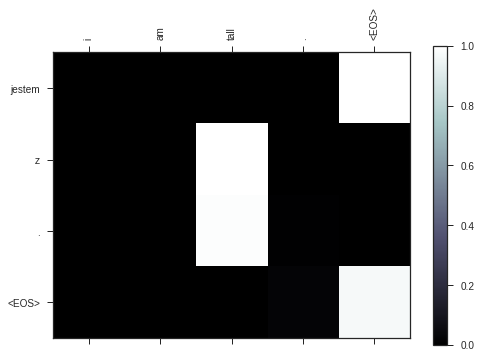

In [29]:
evaluate_and_show_attention("i am tall .")

# Ćwiczenia

* Spróbuj użyć innego zestawu danych
     * Kolejna para językowa
     * Człowiek &rarr; Maszyna (np. Komendy IOT)
     * Czat irarr; Odpowiedź
     * Pytanie irarr; Odpowiedź
* Zastąp osadzone wcześniej słowa, takie jak word2vec lub GloVe
* Wypróbuj więcej warstw, więcej ukrytych jednostek i więcej zdań. Porównaj czas trenowania i wyniki.
* Jeśli używasz pliku tłumaczenia, w którym pary mają dwie takie same frazy (`I am test \t I am test`), możesz użyć tego jako automatycznego enkodera. Spróbuj tego:
     * Trenuj jako autoencoder
     * Zapisz tylko sieć Encoder
     * Wytrenuj nowy Dekoder do tłumaczenia z tego miejsca
